# Import libraries

In [1]:
import torch

import os
import random
import pandas
import numpy
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# seed = 7777
# random.seed(seed) 
# torch.manual_seed(seed);

# Load Saved MP (Magnetic Parameter) Model

In [2]:
# 12 input -> 42 output
class MpModel(torch.nn.Module):
    def __init__(self):
        super(MpModel, self).__init__()

        self.linear1 = torch.nn.Linear(12, 100, bias=True)
        self.linear2 = torch.nn.Linear(100, 100, bias=True)
        self.linear3 = torch.nn.Linear(100, 42, bias=True)

    def forward(self, x):
        x = torch.atan(self.linear1(x))
        x = torch.atan(self.linear2(x))
        x = torch.atan(self.linear2(x))
        x = self.linear3(x)
        return x


mp_model = MpModel().to("cuda")
mp_model.load_state_dict(torch.load("saved_model_state.pt"))

for param in mp_model.parameters():
    param.requires_grad = False

# Create GP (Geometry Paramter) Generator

In [3]:
class GpModel(torch.nn.Module):
    def __init__(self, input_length: int):
        super(GpModel, self).__init__()

        self.dense_layer1 = torch.nn.Linear(int(input_length), 128)
        self.dense_layer2 = torch.nn.Linear(128, 256)
        # self.dense_layer3 = torch.nn.Linear(256, 512)
        # self.dense_layer4 = torch.nn.Linear(512, 256)
        self.dense_layer5 = torch.nn.Linear(256, 128)
        self.dense_layer6 = torch.nn.Linear(128, int(input_length))
        
        self.batch_norm1 = torch.nn.LazyBatchNorm1d()
        self.batch_norm2 = torch.nn.LazyBatchNorm1d()
        self.batch_norm3 = torch.nn.LazyBatchNorm1d()
        self.batch_norm4 = torch.nn.LazyBatchNorm1d()
        self.batch_norm5 = torch.nn.LazyBatchNorm1d()

    def forward(self, x):
        x = self.batch_norm1(torch.atan(self.dense_layer1(x)))
        x = self.batch_norm2(torch.atan(self.dense_layer2(x)))
        # x = self.batch_norm3(torch.atan(self.dense_layer3(x)))
        # x = self.batch_norm4(torch.atan(self.dense_layer4(x)))
        x = self.batch_norm5(torch.atan(self.dense_layer5(x)))
        x = torch.sigmoid(self.dense_layer6(x))
        return x


gp_model = GpModel(10).to("cuda")
optimizer = torch.optim.Adam(gp_model.parameters(), lr=3e-4)

C:\Users\arist\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# System Constraints

In [4]:
# x-direction of the primary winding (mm)
lpx_min, lpx_max = (50.0, 650.0)

# y-direction of the primary winding (mm)
lpy_min, lpy_max = (50.0, 2050.0)

# width of the primary winding (mm)
wp_min, wp_max = (25.0, 325.0)

# length of the edge of the primary core (mm)
a_min, a_max = (0.0, 200.0)

# pitch of the adjacent cores (mm)
p_min, p_max = (0.0, 200.0)

# length of the secondary winding (mm)
ls_min, ls_max = (50.0, 450.0)

# width of the secondary winding (mm)
ws_min, ws_max = (25.0, 225.0)

# input RMS current (A)
ip_min, ip_max = (50.0, 200.0)

# turn number of the primary side
np_min, np_max = (4.0, 10.0)

# turn number of the secondary side
ns_min, ns_max = (4.0, 10.0)

# switching frequency (kHz)
f = 85 * (10 ** 3)

# output power at the center (kW)
p_out = 50 * (10 ** 3)

# input DC voltage (V)
v_dc = 400

# output DC voltage (V)
v_bat = 400

# length of the edge of the secondary core
b = 50

# ???
w = 2 * numpy.pi * f  # [rad/s]

# ???
q_coil = 400

# Helper functions

In [5]:
# Creates a tensor of shape [num, *start.shape] whose values are evenly spaced from start to end, inclusive.
# Replicates but the multi-dimensional bahaviour of numpy.linspace in PyTorch.

@torch.jit.script
def linspace(start: torch.Tensor, stop: torch.Tensor, num: int):
    # create a tensor of 'num' steps from 0 to 1
    steps = torch.arange(num, dtype=torch.float32, device=start.device) / (num - 1)

    # reshape the 'steps' tensor to [-1, *([1]*start.ndim)] to allow for broadcastings
    # - using 'steps.reshape([-1, *([1]*start.ndim)])' would be nice here but torchscript
    #   "cannot statically infer the expected size of a list in this contex", hence the code below
    for i in range(start.ndim):
        steps = steps.unsqueeze(-1)

    # the output starts at 'start' and increments until 'stop' in each dimension
    out = start[None] + steps * (stop - start)[None]

    return out

In [6]:
# Generate a pytorch tensor full of random floats in the range [-1, +1] with the given shape

def generate_noise(shape):
    return torch.distributions.uniform.Uniform(-1, +1).sample(shape).cuda()

In [7]:
def stack_parameters(*params):
    return torch.stack(params).transpose(0, 1)


# Scale an array to be between our specified [min, max] contraints
def scale(arr):
    scaler_min = torch.tensor(
        [a_min, lpx_min, lpy_min, ls_min, p_min, wp_min, ws_min, ip_min, np_min, ns_min],
        device="cuda",
    )
    scaler_max = torch.tensor(
        [a_max, lpx_max, lpy_max, ls_max, p_max, wp_max, ws_max, ip_max, np_max, ns_max],
        device="cuda",
    )

    return arr * (scaler_max - scaler_min) + scaler_min


def extract(arr):
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns = [
        numpy.squeeze(x) for x in numpy.hsplit(arr, 10)
    ]

    ys_min = (
        5 * wp +
        4 * a +
        3 * lpy +
        2 * p
    )

    ys_max = (lpy + wp)
    ys_max = ys_min + (ys_min - ys_max) / 2

    ys_min /= 2
    ys_max /= 2

    ys = linspace(ys_min, ys_max, num=5)

    np = torch.round(np)
    ns = torch.round(ns)

    # take all 15 tensors of shape (X) and convert to (15, X)
    return a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys


def scale_and_extract(arr):
    scaled_array = scale(arr)
    return extract(scaled_array)

In [8]:
# Enclose in a function so we don't leak variables
def test_models():
    noise = generate_noise(shape=(256, 10))
    gp = gp_model(noise)
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)

    gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
    extra_parameters = stack_parameters(ip, np, ns)

    mp = mp_model(gp_parameters)

    print(f"""
    GP Parameters Shape:    {gp_parameters.shape}
    Extra Parameters Shape: {extra_parameters.shape}
    MP Model Output Shape:  {mp.shape}
    """)
test_models()


    GP Parameters Shape:    torch.Size([256, 12])
    Extra Parameters Shape: torch.Size([256, 3])
    MP Model Output Shape:  torch.Size([256, 42])
    


In [9]:
"""
Method to take two equally-sized lists and return just the elements which lie 
on the Pareto frontier, sorted into order.
Default behaviour is to find the maximum for both X and Y, but the option is
available to specify maxX = False or maxY = False to find the minimum for either
or both of the parameters.
"""


def pareto_frontier(x, y, max_x=False):
    if max_x:
        return _pareto_frontier(y, x)
    else:
        return _pareto_frontier(x, y)


def _pareto_frontier(x, y):
    # Combine inputs and sort them with smallest X values coming first
    sorted_xy = sorted(zip(x, y))
    p_front_x = torch.zeros(len(x), device="cuda")
    p_front_y = torch.zeros(len(y), device="cuda")
    
    # Loop through the sorted list
    #   Look for lower values of Y…
    #   and add them to the Pareto frontier
    min_y = sorted_xy[0][1]
    for index in range(len(sorted_xy)):
        x, y = sorted_xy[index]
        if y < min_y:
            min_y = y
            p_front_x[index] = x
            p_front_y[index] = y
            
    p_front_x = p_front_x[p_front_x.nonzero()]
    p_front_y = p_front_y[p_front_y.nonzero()]

    return p_front_x, p_front_y

In [10]:
def y_util(x, a, b):
    return (1 / (x ** b)) ** (1 / a)

In [11]:
def log_util(x, a, b):
    return ()

In [12]:
def lin_util(x, a, b):
    return ((a * x) + b)

In [13]:
def prod_util(x, a):
    return (1 / (x * a))

In [14]:
def prodb_util(x, a, b):
    return ((1 / (x * a)) + b)

In [15]:
def one_param_util(x, a):
    return ((1 - (x**a))**(1/a))

In [16]:
def one_param_b_util(x, a, b):
    return (((1 - (x**a))**(1/a)) + b)

In [17]:
#testing for creating total pareto f

def oldgraph_pareto_frontier(Xs, Ys, maxX = False, maxY = False):
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
      if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
          p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

# Load DWPT data

In [18]:
def load_dwpt():
    folder_name = "./dwpt_v5"
    file_names = [
        "DWPT_v5_N10",
        "DWPT_v5_N100",
        "DWPT_v5_N200",
        "DWPT_v5_N300",
        "DWPT_v5_N400",
    ]

    df = pandas.DataFrame()

    for file_name in file_names:
        new_df = pandas.read_csv(f"{folder_name}/{file_name}_after.csv", index_col=0)
        df = pandas.concat([df, new_df])

    return df

df = load_dwpt()
df_gp = df.loc[:, :"ys4[mm]"]
df_mp = df.loc[:, "k0mm_ys0":]

print(df_gp.shape)
print(df_mp.shape)

(1010, 12)
(1010, 42)


# Define Loss Functions

In [19]:
def kdiff_loss(k_parameters):
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters

    kdiff = abs(k_0_0 - k_1_0)
    kdiff = kdiff / torch.max(abs(k_0_0), abs(k_1_0))

    # their kdiff - why is there a difference?
    #   kdiff = abs(k00 - k10) / k00

    return kdiff



def bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters):
    # Unpack parameters
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters
    (
        lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
        ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
        lp_1_0, ls_1_0,
    ) = l_parameters
    (
        bx_p_0_00, by_p_0_00, bz_p_0_00,
        bx_p_0_90, by_p_0_90, bz_p_0_90,
        bx_s_0_00, by_s_0_00, bz_s_0_00,
        bx_s_0_90, by_s_0_90, bz_s_0_90,

        bx_p_1_00, by_p_1_00, bz_p_1_00,
        bx_p_1_90, by_p_1_90, bz_p_1_90,
        bx_s_1_00, by_s_1_00, bz_s_1_00,
        bx_s_1_90, by_s_1_90, bz_s_1_90,
    ) = b_parameters
    (
        ip, np, ns
    ) = extra_parameters

    # Scale l_parameters
    lp_0_0 = lp_0_0 * np ** 2
    ls_0_0 = ls_0_0 * ns ** 2

    # Calculate Is
    # n1 = (numpy.pi * w) * (lp_0_0 * 10 ** -9) * (ip * numpy.sqrt(2) / (4 * v_dc))
    # t1 = (numpy.pi) ** 2 * w * (lp_0_0 * 10 ** -9 * ls_0_0 * 10 ** -9) ** 0.5
    # t2 = p_out / (8 * k_0_0 * n1 * v_dc * v_bat)
    # n2 = t1 * t2
    # # "Is" is way too big?
    # Is = 4 * n2 * v_bat / (numpy.pi * w * ls_0_0 * 10 ** -9) / numpy.sqrt(2)
    
    # Paper formula
    n1 = (torch.pi * w * lp_0_0 * ip) / (2 * numpy.sqrt(2) * v_dc)
    t1 = (torch.pi ** 2 * w * p_out * torch.sqrt(lp_0_0 * ls_0_0))
    t2 = 8 * k_0_0 * n1 * v_dc * v_bat
    n2 = t1 / t2
    Is = (4 * v_bat * n2) / (torch.pi * w * ls_0_0)

    # Calculate B_0mm - unneeded since b100mm always bigger?
    # bx_0 = (
    #     (bx_p_0_00 * ip * np + bx_s_0_00 * Is * ns) ** 2 +
    #     (bx_p_0_90 * ip * np + bx_s_0_90 * Is * ns) ** 2
    # ) ** 0.5
    # by_0 = (
    #     (by_p_0_00 * ip * np + by_s_0_00 * Is * ns) ** 2 +
    #     (by_p_0_90 * ip * np + by_s_0_90 * Is * ns) ** 2
    # ) ** 0.5
    # bz_0 = (
    #     (bz_p_0_00 * ip * np + bz_s_0_00 * Is * ns) ** 2 +
    #     (bz_p_0_90 * ip * np + bz_s_0_90 * Is * ns) ** 2
    # ) ** 0.5
    # b_0 = (bx_0**2 + by_0**2 + bz_0**2) ** 0.5

    # Calculate B_100mm
    bx_100 = (
        (bx_p_1_00 * ip * np + bx_s_1_00 * Is * ns) ** 2 +
        (bx_p_1_90 * ip * np + bx_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    by_100 = (
        (by_p_1_00 * ip * np + by_s_1_00 * Is * ns) ** 2 +
        (by_p_1_90 * ip * np + by_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    bz_100 = (
        (bz_p_1_00 * ip * np + bz_s_1_00 * Is * ns) ** 2 +
        (bz_p_1_90 * ip * np + bz_s_1_90 * Is * ns) ** 2
    ) ** 0.5
    b_100 = (bx_100**2 + by_100**2 + bz_100**2) ** 0.5

    # Bstray is the max between the two targets
    # bstray = torch.max(b_0, b_100)
    bstray = b_100

    return bstray

In [20]:

#     (
#         # [0 thru 5]
#         k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,

#         # [6 thru 17]
#         lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
#         ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
#         lp_1_0, ls_1_0,

#         # [18 thru 29]
#         bx_p_0_00, by_p_0_00, bz_p_0_00,
#         bx_p_0_90, by_p_0_90, bz_p_0_90,
#         bx_s_0_00, by_s_0_00, bz_s_0_00,
#         bx_s_0_90, by_s_0_90, bz_s_0_90,

#         # [30 thru 42]
#         bx_p_1_00, by_p_1_00, bz_p_1_00,
#         bx_p_1_90, by_p_1_90, bz_p_1_90,
#         bx_s_1_00, by_s_1_00, bz_s_1_00,
#         bx_s_1_90, by_s_1_90, bz_s_1_90,
#     )

In [21]:
def coil_loss_and_power_average(k_parameters, l_parameters, b_parameters, extra_parameters):
  (k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,) = k_parameters
  (
      lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
      ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
      lp_1_0, ls_1_0,
  ) = l_parameters
  (
      bx_p_0_00, by_p_0_00, bz_p_0_00,
      bx_p_0_90, by_p_0_90, bz_p_0_90,
      bx_s_0_00, by_s_0_00, bz_s_0_00,
      bx_s_0_90, by_s_0_90, bz_s_0_90,

      bx_p_1_00, by_p_1_00, bz_p_1_00,
      bx_p_1_90, by_p_1_90, bz_p_1_90,
      bx_s_1_00, by_s_1_00, bz_s_1_00,
      bx_s_1_90, by_s_1_90, bz_s_1_90,
  ) = b_parameters
  (
      ip, np, ns
  ) = extra_parameters

  n1_i = math.pi*w*lp_0_0*10**(-9)*ip*math.sqrt(2)/(4*Vdc)
  t1 = (math.pi)**2*w*(lp_0_0*10**(-9)*ls_0_0 *10**(-9))**0.5
  t2 = Pout/(8*lp_0_0*n1_i*Vdc*Vbat)
  n2_i = t1*t2
  Is_i = 4*n2_i*Vbat/(math.pi*w*ls_0_0*10**(-9))/math.sqrt(2)
  loss = w*lp_0_0*10**(-9)*ip**2/QCoil + w*ls_0_0 *10**(-9)*Is_i**2/QCoil

  a6 = lp_0_0.clone() * np.clone()**2  # LP0MM_YSO
  a7 = lp_0_1.clone() * np.clone()**2  # LP0MM_YS1
  a8 = lp_0_2.clone() * np.clone()**2  # LP0MM_YS2
  a9 = lp_0_3.clone() * np.clone()**2  # LP0MM_YS3
  a10 = lp_0_4.clone() * np.clone()**2 # LP0MM_YS4

  a11 = ls_0_0.clone() * ns.clone()**2 # LS0MM_YSO
  a12 = ls_0_1.clone() * ns.clone()**2 # LS0MM_YS1
  a13 = ls_0_2.clone() * ns.clone()**2 # LS0MM_YS2
  a14 = ls_0_3.clone() * ns.clone()**2 # LS0MM_YS3
  a15 = ls_0_4.clone() * ns.clone()**2 # LS0MM_YS4



  p0 = w*k_0_0*(a6*10**(-9))*(a11*10**(-9))**0.5*ip*Is_i
  p1 = w*k_0_1*(a7*10**(-9))*(a12*10**(-9))**0.5*ip*Is_i  
  p2 = w*k_0_2*(a8*10**(-9))*(a13*10**(-9))**0.5*ip*Is_i 
  p3 = w*k_0_3*(a9*10**(-9))*(a14*10**(-9))**0.5*ip*Is_i
  p4 = w*k_0_4*(a10*10**(-9))*(a15*10**(-9))**0.5*ip*Is_i 
  pave = (p0+(2*p1)+(2*p2)+(2*p3)+(2*abs(p4)))/8 
  return loss,pave



In [22]:
def power_average(k_parameters, l_parameters, b_parameters, extra_parameters, gp_parameters):
  
  return 

In [23]:
  def core_losses(k_parameters, l_parameters, b_parameters, extra_parameters, gp_parameters):
    (
        k_0_0, k_0_1, k_0_2, k_0_3, k_0_4, k_1_0,
    ) = k_parameters
    (
        lp_0_0, lp_0_1, lp_0_2, lp_0_3, lp_0_4,
        ls_0_0, ls_0_1, ls_0_2, ls_0_3, ls_0_4,
        lp_1_0, ls_1_0,
    ) = l_parameters
    (
        bx_p_0_00, by_p_0_00, bz_p_0_00,
        bx_p_0_90, by_p_0_90, bz_p_0_90,
        bx_s_0_00, by_s_0_00, bz_s_0_00,
        bx_s_0_90, by_s_0_90, bz_s_0_90,

        bx_p_1_00, by_p_1_00, bz_p_1_00,
        bx_p_1_90, by_p_1_90, bz_p_1_90,
        bx_s_1_00, by_s_1_00, bz_s_1_00,
        bx_s_1_90, by_s_1_90, bz_s_1_90,
    ) = b_parameters
    (
        ip, np, ns
    ) = extra_parameters

    (
        a, lpx, lpy, ls, p, wp, ws, *ys
    ) = gp_parameters.transpose(0,1)

    V_PriCore = (lpy +2*wp+2*a)*(lpx+2*wp+2*a)*5/(10**3) # cm3
    #print(V_PriCore)
    V_SecCore = (ls+2*ws+2*b)**2*5/(10**3) # cm3
    #print(V_SecCore)
    V_PriWind = (2*(lpx+wp)+2*(lpy+wp))*6.6*6.6/(10**3)*np
    V_SecWind = 4*(ls+ws)*6.6*6.6/(10**3)*ns

    V_PriWind_ave = V_PriWind/(lpy+2*wp+2*a+p)*10**3 # cm3/m
    V_PriCore_ave = V_PriCore/(lpy+2*wp+2*a+p)*10**3 # cm3/m

    #print(V_PriWind_ave, V_PriCore_ave)
    return V_PriCore, V_SecCore, V_PriWind, V_SecWind

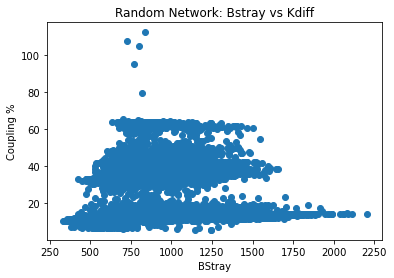

In [24]:
noise = generate_noise(shape=(25_000, 10))
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)

plt.scatter(bstray.detach().cpu(), 100 * kdiff.detach().cpu())
plt.title("Random Network: Bstray vs Kdiff")
plt.xlabel("BStray")
plt.ylabel("Coupling %")
plt.show()

# Neural Network Training Loop

tensor(12.7472, device='cuda:0', grad_fn=<MeanBackward0>)


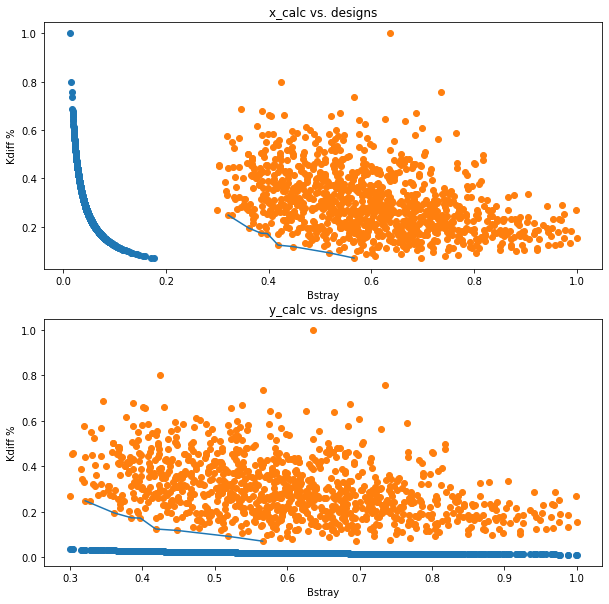

<Figure size 720x360 with 0 Axes>

Epoch:    0
  Combined Loss:  12.7471513748
  Kdiff :         27.0095%
  Bstray :        49.3222
  Pareto Kdiff :  13.2260%
  Pareto Bstray : 35.1508
single point
single point
tensor(6.7505, device='cuda:0', grad_fn=<MeanBackward0>)


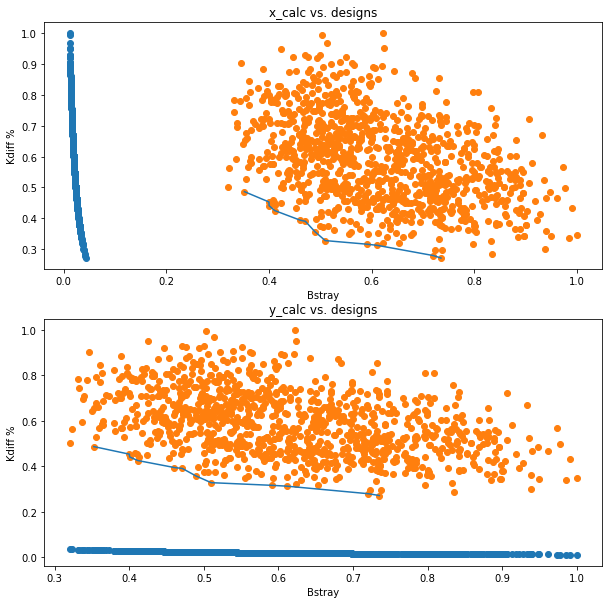

<Figure size 720x360 with 0 Axes>

Epoch:   50
  Combined Loss:  6.7504601479
  Kdiff :         13.1853%
  Bstray :        52.4144
  Pareto Kdiff :  8.2864%
  Pareto Bstray : 43.6866
tensor(4.9279, device='cuda:0', grad_fn=<MeanBackward0>)


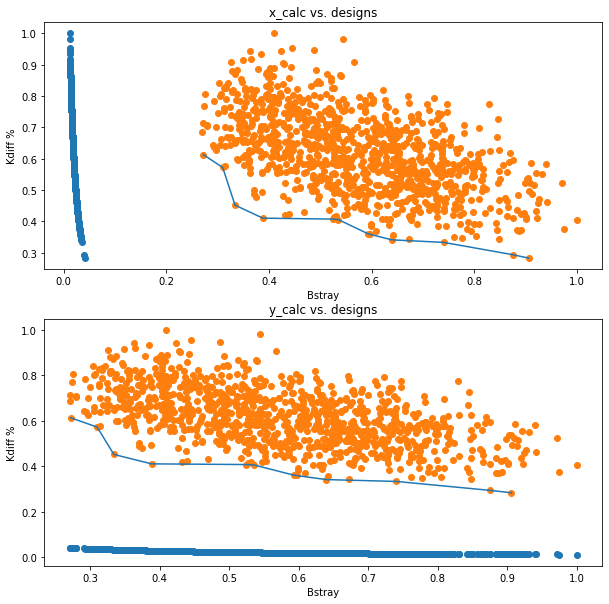

<Figure size 720x360 with 0 Axes>

Epoch:  100
  Combined Loss:  4.9279212952
  Kdiff :         9.5124%
  Bstray :        53.3923
  Pareto Kdiff :  6.2447%
  Pareto Bstray : 52.1267
tensor(4.0442, device='cuda:0', grad_fn=<MeanBackward0>)


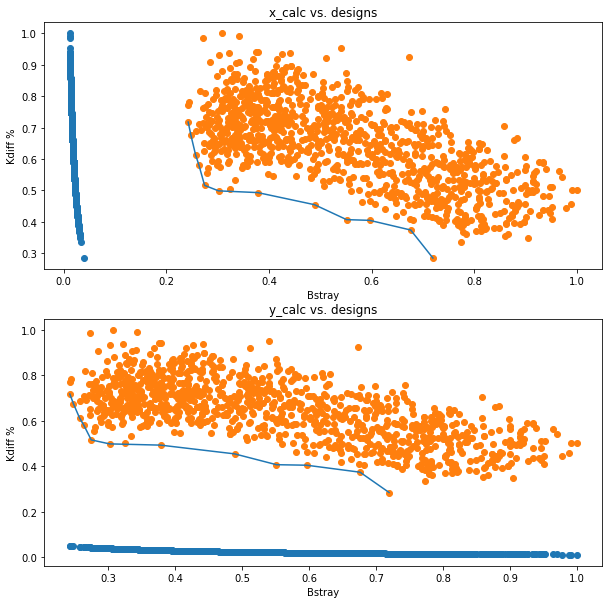

<Figure size 720x360 with 0 Axes>

Epoch:  150
  Combined Loss:  4.0441689491
  Kdiff :         7.9409%
  Bstray :        53.3823
  Pareto Kdiff :  6.1795%
  Pareto Bstray : 40.2057


In [25]:
p_front_x = []
p_front_y = []
pareto_bstray_points = []
pareto_kdiff_points = []
kdiffs = []
bstrays = []
combined_losses = []

#testing for graphs
kdiff_designs = []
bstray_designs = []
pareto_bstray_points2 = []
pareto_kdiff_points2 = []

x_calc_numpy =[]
y_calc_numpy=[]

#training parameters
n_epochs = 200
n_noise = 1000
chosen_curve_util = prod_util
normalize = True

for epoch in range(n_epochs):
    
    # Clear old gradients in the GP model
    for param in gp_model.parameters():
        param.grad = None

    # Create GP parameters from noise
    noise = generate_noise(shape=(n_noise, 10))
    gp = gp_model(noise)

    # Unpack and filter GP parameters
    a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
    gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
    extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

    # Scale GP parameters - why?
    min_x = torch.min(gp_parameters)
    max_x = torch.max(gp_parameters)
    gp_parameters = (gp_parameters - min_x) / (max_x - min_x)

    # Push GP parameters through MP model
    mp_parameters = mp_model(gp_parameters)

    # Scale MP parameters
    y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
    min_y = torch.min(y, 1).values
    max_y = torch.max(y, 1).values
    mp_parameters = mp_parameters * (max_y - min_y) + min_y

    k_parameters = mp_parameters.transpose(0, 1)[0:6]
    l_parameters = mp_parameters.transpose(0, 1)[6:18]
    b_parameters = mp_parameters.transpose(0, 1)[18:]

    # Calculate losses
    kdiff = kdiff_loss(k_parameters)
    bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)
    pareto_bstray, pareto_kdiff = pareto_frontier(bstray, kdiff)
    
    max_kdiff_point = torch.max(kdiff)
    max_bstray_point = torch.max(bstray)
    
    #scale bstray and kdiff
    normalized_kdiff = kdiff / max_kdiff_point
    normalized_bstray = bstray / max_bstray_point
    normalized_pareto_kdiff = pareto_kdiff / max_kdiff_point
    normalized_pareto_bstray = pareto_bstray / max_bstray_point

    
    #add extrema points
    if normalize == True:
        zero_tensor = torch.tensor([[0.01]]).cuda()
        max_tensor = torch.tensor([[1]]).cuda()
        max_tensor_bstray = torch.tensor([[max_bstray_point.cpu().data.numpy() * 2]]).cuda()
        max_tensor_kdiff = torch.tensor([[max_kdiff_point.cpu().data.numpy() * 2]]).cuda()
    else:
        zero_tensor = torch.tensor([[0.001]]).cuda()
        max_tensor = torch.tensor([[100]]).cuda()
        max_tensor_bstray = torch.tensor([[max_bstray_point.cpu().data.numpy() * 2]]).cuda()
        max_tensor_kdiff = torch.tensor([[max_kdiff_point.cpu().data.numpy() * 2]]).cuda()
        
    normalized_pareto_bstray_added = torch.cat((zero_tensor, normalized_pareto_bstray, max_tensor),0)
    normalized_pareto_kdiff_added = torch.cat((max_tensor, normalized_pareto_kdiff, zero_tensor),0)
    
    pareto_bstray_added = torch.cat((zero_tensor, pareto_bstray, max_tensor_bstray),0)
    pareto_kdiff_added = torch.cat((max_tensor_kdiff, pareto_kdiff, zero_tensor),0)
    # pareto_bstray_added = pareto_bstray
    # pareto_kdiff_added = pareto_kdiff
    
    #numpy conversions for curve fit and plotting
    normalized_bstray_numpy = normalized_bstray.cpu().data.numpy()
    normalized_kdiff_numpy = normalized_kdiff.cpu().data.numpy()
    
    normalized_pareto_bstray_numpy = normalized_pareto_bstray.cpu().data.numpy()
    normalized_pareto_kdiff_numpy = normalized_pareto_kdiff.cpu().data.numpy()
    
    normalized_pareto_bstray_added_numpy = normalized_pareto_bstray_added.cpu().data.numpy()
    normalized_pareto_kdiff_added_numpy = normalized_pareto_kdiff_added.cpu().data.numpy()
    
    
    pareto_bstray_added_numpy = pareto_bstray_added.cpu().data.numpy()
    pareto_kdiff_added_numpy = pareto_kdiff_added.cpu().data.numpy()
    pareto_bstray_numpy = pareto_bstray.cpu().data.numpy()
    pareto_kdiff_numpy = pareto_kdiff.cpu().data.numpy()
    bstray_numpy = bstray.cpu().data.numpy()
    kdiff_numpy = kdiff.cpu().data.numpy()
    

    #compute delta y loss from utility fit function    
    if len(pareto_kdiff_numpy) > 2:
        
        if (chosen_curve_util == one_param_util) or (chosen_curve_util == prod_util):
            if normalize == True:
                (a), pcov = curve_fit(chosen_curve_util, normalized_pareto_kdiff_added_numpy[:,0], normalized_pareto_bstray_added_numpy[:,0], maxfev = 3000)
            else:
                (a), pcov = curve_fit(chosen_curve_util, pareto_kdiff_added_numpy[:,0], pareto_bstray_added_numpy[:,0], maxfev = 3000)
        
        if (chosen_curve_util == y_util) or (chosen_curve_util == lin_util) or (chosen_curve_util == prodb_util) or (chosen_curve_util == one_param_b_util):
            if normalize == True:
                (a, b), pcov = curve_fit(chosen_curve_util, normalized_pareto_kdiff_added_numpy[:,0], normalized_pareto_bstray_added_numpy[:,0], maxfev = 3000)
            else:
                (a, b), pcov = curve_fit(lin_util, pareto_kdiff_added_numpy[:,0], pareto_bstray_added_numpy[:,0], maxfev = 3000)
                # (a, b), pcov = curve_fit(lin_util, pareto_kdiff_numpy[:,0], pareto_bstray_numpy[:,0], maxfev = 3000)
            
        
        #one param util
        if chosen_curve_util == one_param_util:
            if normalize == True:
                x_calc = torch.as_tensor((1 / (normalized_kdiff_numpy ** a)) ** (1 / a)).cuda()
            else:
                x_calc = torch.as_tensor((1 / (kdiff_numpy ** a)) ** (1 / a)).cuda()
                
        #one param with intercept util
        if chosen_curve_util == one_param_b_util:
            if normalize == True:
                x_calc = torch.as_tensor(((1 / (normalized_kdiff_numpy ** a)) ** (1 / a)) + b).cuda()
            else:
                x_calc = torch.as_tensor(((1 / (kdiff_numpy ** a)) ** (1 / a)) + b).cuda()
        
        #exponential utils
        if chosen_curve_util == y_util:
            
            if normalize == True:
                x_calc = torch.as_tensor(((1 / normalized_kdiff_numpy ** b)) ** (1 / a)).cuda()
            else:
                x_calc = torch.as_tensor(((1 / kdiff_numpy ** b)) ** (1 / a)).cuda()
        
        #prod util
        if chosen_curve_util == prod_util:
            if normalize == True:
                x_calc = torch.as_tensor(1 / (normalized_kdiff_numpy * a)).cuda()
            else:
                x_calc = torch.as_tensor(1 / (kdiff_numpy * a)).cuda()
        
        #prodb util
        if chosen_curve_util == prodb_util:
            if normalize == True:
                x_calc = torch.as_tensor((1 / (normalized_kdiff_numpy * a)) + b).cuda()
            else:
                x_calc = torch.as_tensor((1 / (kdiff_numpy * a)) + b).cuda()
        
        #linear util
        if chosen_curve_util == lin_util:
            if normalize == True:
                x_calc = torch.as_tensor((a * normalized_kdiff_numpy) + (b)).cuda()
            else:
                x_calc = torch.as_tensor((a * kdiff_numpy) + (b)).cuda() 
            
        x_calc_numpy = x_calc.cpu().data.numpy()
        #x_loss = torch.abs(x_calc - bstray)
        
        if normalize == True:
            x_loss = x_calc - normalized_bstray
        else:
            x_loss = x_calc - bstray
        x_loss_relu = torch.nn.functional.relu(-x_loss)
        
    elif len(pareto_bstray_numpy) > 0:
        x_loss = pareto_bstray[:,0]
        print('single point')
    
    if len(pareto_bstray_numpy) > 2:
        if (chosen_curve_util == one_param_util) or (chosen_curve_util == prod_util):
            if normalize == True:
                (a), pcov = curve_fit(chosen_curve_util, normalized_pareto_bstray_added_numpy[:,0], normalized_pareto_kdiff_added_numpy[:,0], maxfev = 3000)
            else:
                (a), pcov = curve_fit(chosen_curve_util, pareto_bstray_added_numpy[:,0], pareto_kdiff_added_numpy[:,0], maxfev = 3000)
        
        if (chosen_curve_util == y_util) or (chosen_curve_util == lin_util) or (chosen_curve_util == prodb_util) or (chosen_curve_util == one_param_b_util):
            if normalize == True:
                (a, b), pcov = curve_fit(chosen_curve_util, normalized_pareto_bstray_added_numpy[:,0], normalized_pareto_kdiff_added_numpy[:,0], maxfev = 3000)
            else:
                (a, b), pcov = curve_fit(lin_util, pareto_bstray_added_numpy[:,0], pareto_kdiff_added_numpy[:,0], maxfev = 3000)
                # (a, b), pcov = curve_fit(lin_util, pareto_bstray_numpy[:,0], pareto_kdiff_numpy[:,0], maxfev = 3000)
            
        
        #one param util
        if chosen_curve_util == one_param_util:
            if normalize == True:
                y_calc = torch.as_tensor((1 / (normalized_bstray_numpy ** a)) ** (1 / a)).cuda()
            else:
                y_calc = torch.as_tensor((1 / (bstray_numpy ** a)) ** (1 / a)).cuda()
                
        #one param with intercept util
        if chosen_curve_util == one_param_b_util:
            if normalize == True:
                y_calc = torch.as_tensor(((1 / (normalized_bstray_numpy ** a)) ** (1 / a)) + b).cuda()
            else:
                y_calc = torch.as_tensor(((1 / (bstray_numpy ** a)) ** (1 / a)) + b).cuda()
                
        #exponential utils
        if chosen_curve_util == y_util:
            if normalize == True:
        
                y_calc = torch.as_tensor(((1 / normalized_bstray_numpy ** b)) ** (1 / a)).cuda()
            else:
                y_calc = torch.as_tensor(((1 / bstray_numpy ** b)) ** (1 / a)).cuda()
        
        #prod util
        if chosen_curve_util == prod_util:
            if normalize == True:
                y_calc = torch.as_tensor(1 / (normalized_bstray_numpy * a)).cuda()
            else:
                y_calc = torch.as_tensor(1 / (bstray_numpy * a)).cuda()
                
        #prodb util
        if chosen_curve_util == prodb_util:
            if normalize == True:
                y_calc = torch.as_tensor((1 / (normalized_bstray_numpy * a)) + b).cuda()
            else:
                y_calc = torch.as_tensor((1 / (bstray_numpy * a)) + b).cuda()
        
        #linear util
        if chosen_curve_util == lin_util:
            if normalize == True:
                y_calc = torch.as_tensor(((a * normalized_bstray_numpy)) + (b)).cuda()
            else:
                y_calc = torch.as_tensor(((a * bstray_numpy)) + (b)).cuda()
        
        y_calc_numpy = y_calc.cpu().data.numpy()
       
        if normalize == True:
            y_loss = y_calc - normalized_kdiff   
        else:
            y_loss = y_calc - kdiff
        y_loss_relu = torch.nn.functional.relu(-y_loss)
        
    elif len(pareto_bstray_numpy) > 0:
        y_loss = pareto_kdiff[:,0]
        print('single point')

    # loss

    if len(pareto_bstray) > 0 and len(pareto_kdiff) > 0:
        #combined_loss = torch.mean(torch.log(y_loss + 1))
        # combined_loss = torch.sum(y_loss_relu * x_loss_relu)
        combined_loss = torch.mean(bstray * kdiff)

    else: 
        combined_loss = torch.zeros(1, requires_grad=True)
        print('No new pareto points found, used zero grad')

    # Push loss through the optimizer and update the GP model
    try:
        combined_loss.backward(retain_graph=True)
        optimizer.step()
    except Exception as e:
        print(f"Error on epoch {epoch} regarding", e)
        break

    
    if epoch % 50 == 0:
        
        print(combined_loss)
        figure, axis = plt.subplots(2, 1, figsize=(10,10))
        plt.figure(figsize=(10, 5))
        
        if normalize == True:
            axis[0].plot(normalized_pareto_bstray_numpy, normalized_pareto_kdiff_numpy)
            axis[0].scatter(x_calc.cpu().data.numpy(), normalized_kdiff_numpy)
            axis[0].scatter(normalized_bstray_numpy, normalized_kdiff_numpy)
            axis[0].set_xlabel("Bstray")
            axis[0].set_ylabel("Kdiff %")
            axis[0].set_title("x_calc vs. designs")
            
            axis[1].plot(normalized_pareto_bstray_numpy, normalized_pareto_kdiff_numpy)
            axis[1].scatter(normalized_bstray_numpy, y_calc.cpu().data.numpy())
            axis[1].scatter(normalized_bstray_numpy, normalized_kdiff_numpy)
            axis[1].set_xlabel("Bstray")
            axis[1].set_ylabel("Kdiff %")
            axis[1].set_title("y_calc vs. designs")
        else:
            axis[0].plot(pareto_bstray_numpy, pareto_kdiff_numpy)
            axis[0].scatter(x_calc.cpu().data.numpy(), kdiff_numpy)
            axis[0].scatter(bstray_numpy, kdiff_numpy)
            axis[0].set_xlabel("Bstray")
            axis[0].set_ylabel("Kdiff %")
            axis[0].set_title("x_calc vs. designs")
            
            axis[1].plot(pareto_bstray_numpy, pareto_kdiff_numpy)
            axis[1].scatter(bstray_numpy, y_calc.cpu().data.numpy())
            axis[1].scatter(bstray_numpy, kdiff_numpy)
            axis[1].set_xlabel("Bstray")
            axis[1].set_ylabel("Kdiff %")
            axis[1].set_title("y_calc vs. designs")
            
            
        # plt.xlim([0,100])
        # plt.ylim([0,0.5])
        plt.show()
        #paretopoints graphing test
        pareto_bstray_test, pareto_kdiff_test = oldgraph_pareto_frontier(bstray.cpu().detach().numpy(), kdiff.cpu().detach().numpy())
        pareto_bstray_points2.append(pareto_bstray_test)
        pareto_kdiff_points2.append(pareto_kdiff_test)

        # Store metrics for plotting or further logging
        combined_losses.append(combined_loss.cpu().data.numpy())
        kdiffs.append(torch.mean(kdiff).cpu().data.numpy())
        bstrays.append(torch.mean(bstray).cpu().data.numpy())
        kdiff_designs.append(kdiff.cpu().data.numpy())
        bstray_designs.append(bstray.cpu().data.numpy())
        
        p_front_x.append(pareto_bstray)
        p_front_y.append(pareto_kdiff)
        pareto_bstray_points.append(pareto_bstray[:].cpu().detach().numpy())
        pareto_kdiff_points.append(pareto_kdiff[:].cpu().detach().numpy())


        print(f"Epoch: {epoch:4d}")
        print(f"  Combined Loss:  {combined_losses[-1]:.10f}")
        print(f"  Kdiff :         {100 * kdiffs[-1]:.4f}%")
        print(f"  Bstray :        {bstrays[-1]:.4f}")
        print(f"  Pareto Kdiff :  {100 * torch.mean(p_front_y[-1]).cpu().data.numpy():.4f}%")
        print(f"  Pareto Bstray : {torch.mean(p_front_x[-1]).cpu().data.numpy():.4f}")

        # Save model for further training or testing
        torch.save(gp_model, f"./models/gp_model_{epoch:06}.pt")

# Plotting

4
4
13 13


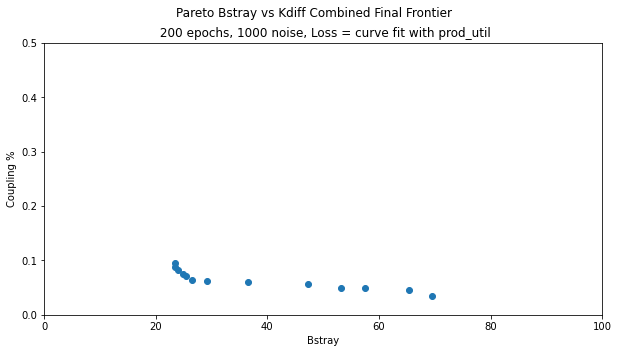

In [26]:
#scatter plot of final pareto points
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff Combined Final Frontier")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = curve fit with {chosen_curve_util.__name__}")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.5])

print(len(pareto_bstray_points2[:]))
print(len(pareto_kdiff_points2[:]))
# print(pareto_bstray_points2[:])
final_x = []
for list in pareto_bstray_points2:
    for item in list:
        final_x.append(item)


final_y = []
for list in pareto_kdiff_points2:
    for item in list:
        final_y.append(item)

final_x, final_y = oldgraph_pareto_frontier(final_x, final_y)
print(len(final_x),len(final_y))

plt.scatter(final_x, final_y)
plt.show() 

4
4
13 13


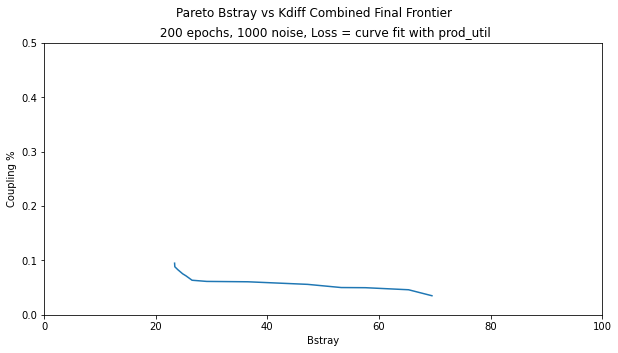

In [27]:
#line plot of final pareto points

plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff Combined Final Frontier")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = curve fit with {chosen_curve_util.__name__}")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.50])

print(len(pareto_bstray_points2[:]))
print(len(pareto_kdiff_points2[:]))
# print(pareto_bstray_points2[:])
final_x = []
for list in pareto_bstray_points2:
    for item in list:
        final_x.append(item)


final_y = []
for list in pareto_kdiff_points2:
    for item in list:
        final_y.append(item)

final_x, final_y = oldgraph_pareto_frontier(final_x, final_y)
print(len(final_x),len(final_y))

plt.plot(final_x, final_y)
plt.show() 

4 4


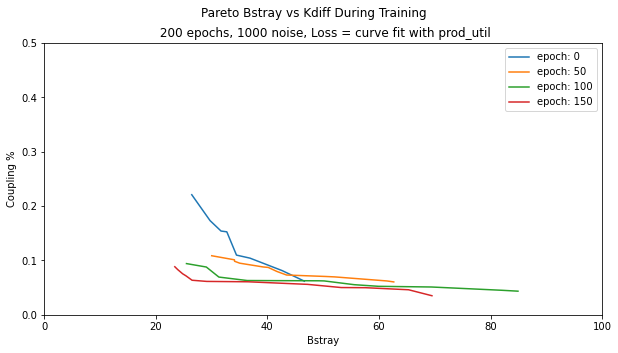

'\nplt.figure(figsize=(10, 5))\nplt.title(f"Pareto Kdiff During Training")\nplt.xlabel("Epoch")\nplt.ylabel("Coupling %")\n\nfor x in pareto_kdiff_points:\n    plt.plot(x)\nplt.show()\n'

In [28]:
i = 0
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff During Training")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = curve fit with {chosen_curve_util.__name__}")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.50])

print(len(pareto_bstray_points), len(pareto_kdiff_points))

while i < len(pareto_bstray_points):
    plt.plot(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*50}")
    # plt.plot(pareto_bstray_points[i], pareto_kdiff_points[i])
    i+=1
plt.legend()
plt.savefig('Pareto_Bstray_Kdiff_1000Epoch_256Noise_linfit.png')
plt.show()


'''
plt.figure(figsize=(10, 5))
plt.title(f"Pareto Kdiff During Training")
plt.xlabel("Epoch")
plt.ylabel("Coupling %")

for x in pareto_kdiff_points:
    plt.plot(x)
plt.show()
'''

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4 4


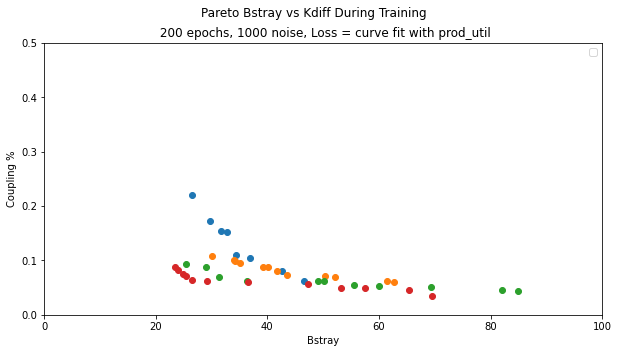

In [29]:
i = 0
plt.figure(figsize=(10, 5))
plt.suptitle(f"Pareto Bstray vs Kdiff During Training")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = curve fit with {chosen_curve_util.__name__}")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.50])

print(len(pareto_bstray_points), len(pareto_kdiff_points))

while i < len(pareto_bstray_points):
    #plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*100}")
    plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i])
    i+=1
plt.legend()
plt.savefig('Pareto_Bstray_Kdiff_1000Epoch_256Noise_linfit.png')
plt.show()

4
4 4


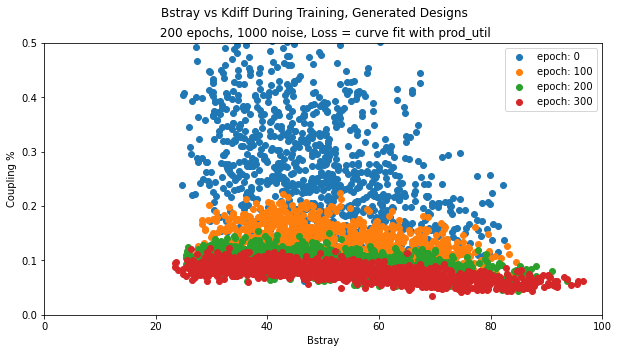

In [30]:
i = 0
print(len(bstray_designs))
#colors = numpy.arange(len(bstray_designs))
colors = numpy.arange(1000)
plt.figure(figsize=(10, 5))
plt.suptitle(f"Bstray vs Kdiff During Training, Generated Designs")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = curve fit with {chosen_curve_util.__name__}")
plt.xlabel("Bstray")
plt.ylabel("Coupling %")
plt.xlim([0,100])
plt.ylim([0,0.50])

print(len(bstrays), len(kdiffs))

while i < len(bstray_designs):
    #plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*100}")
    #fig = plt.scatter(bstray_designs[i], kdiff_designs[i],c=i, cmap='viridis')
    fig = plt.scatter(bstray_designs[i], kdiff_designs[i], label = f"epoch: {i*100}")
    i+=1
    
# plt.colorbar()
plt.legend()
# from matplotlib.patches import Rectangle
# someX, someY = 45, 0.5
# fig,ax = plt.subplots()
# currentAxis = plt.gca()
# currentAxis.add_patch(Rectangle((someX -0.1, someY-0.1), 0.2, 0.2, alpha=0.5, facecolor='red'))
#plt.savefig('Bstray_Kdiff_1000Epoch_256Noise_linfit.png')
plt.show()

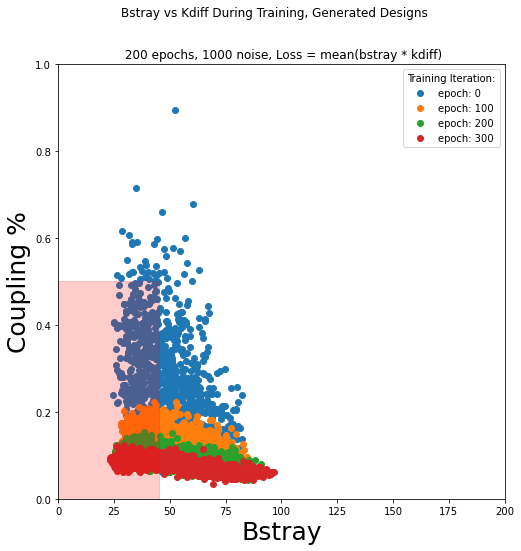

In [36]:
i= 0
fig, ax = plt.subplots()

while i < len(bstray_designs):
    #plt.scatter(pareto_bstray_points[i], pareto_kdiff_points[i], label = f"epoch: {i*100}")
    #fig = plt.scatter(bstray_designs[i], kdiff_designs[i],c=i, cmap='viridis')
    ax.scatter(bstray_designs[i], kdiff_designs[i], label = f"epoch: {i*100}")
    i+=1

plt.xlim(0,200)
plt.ylim(0,1.0)
plt.legend(title='Training Iteration:')
plt.xlabel("Bstray", fontsize = 25)
plt.ylabel('Coupling %', fontsize = 25)
plt.suptitle(f"Bstray vs Kdiff During Training, Generated Designs")
# plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = curve fit with {chosen_curve_util.__name__}")
plt.title(f" {n_epochs} epochs, {n_noise} noise, Loss = mean(bstray * kdiff)")

rect = patches.Rectangle(( 0,0 ), 45, 0.5, alpha = 0.2, ec = "Crimson", fc = "Red", visible = True)
ax.add_patch(rect)
plt.rcParams["figure.figsize"] = (8,8)
# plt.suptitle("Improvement over 1000 training iterations", fontsize = 20, y=1.01)
plt.show()

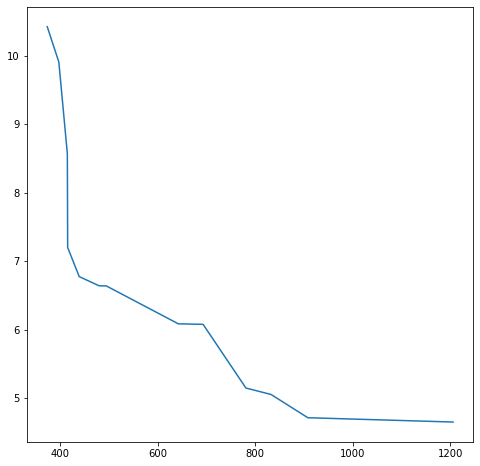

In [32]:
noise = generate_noise(shape=(10_000, 10))
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)

pareto_bstray, pareto_kdiff = pareto_frontier(bstray, kdiff)
pareto_kdiff = pareto_kdiff * 100

plt.plot(pareto_bstray.detach().cpu(), pareto_kdiff.detach().cpu())

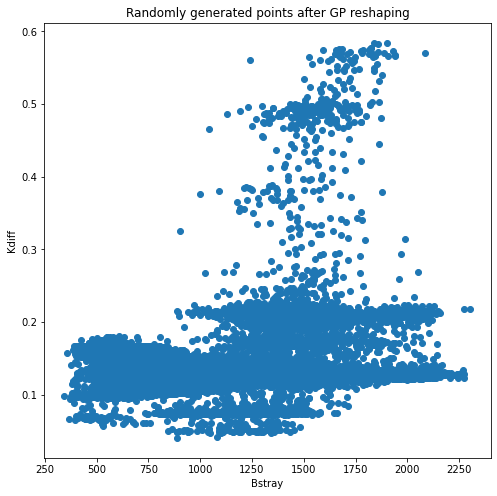

In [33]:
noise = generate_noise(shape=(25_000, 10))
gp = gp_model(noise)

# Unpack and filter GP parameters
a, lpx, lpy, ls, p, wp, ws, ip, np, ns, ys = scale_and_extract(gp)
gp_parameters = stack_parameters(a, lpx, lpy, ls, p, wp, ws, *ys)
extra_parameters = stack_parameters(ip, np, ns).transpose(0, 1)

# Push GP parameters through MP model
mp_parameters = mp_model(gp_parameters)

# Scale MP parameters
y = torch.Tensor(df_mp.values).transpose(0, 1).to("cuda")
min_y = torch.min(y, 1).values
max_y = torch.max(y, 1).values
mp_parameters = mp_parameters * (max_y - min_y) + min_y

k_parameters = mp_parameters.transpose(0, 1)[0:6]
l_parameters = mp_parameters.transpose(0, 1)[6:18]
b_parameters = mp_parameters.transpose(0, 1)[18:]

# Calculate losses
kdiff = kdiff_loss(k_parameters)
bstray = bstray_loss(k_parameters, l_parameters, b_parameters, extra_parameters)

plt.scatter(bstray.detach().cpu(), kdiff.detach().cpu())
plt.title("Randomly generated points after GP reshaping")
plt.xlabel("Bstray")
plt.ylabel("Kdiff")
plt.show()

In [34]:
noise = generate_noise(shape=(3, 10))
gp = gp_model(noise)

noise = noise.cpu().numpy()
gp = gp.cpu().detach().numpy()

for i in range(3):
    print(f"Noise {i}")
    print(noise[i])
    print()
    print(f"Generated Parameters {i}")
    print(gp[i])
    print()

Noise 0
[-0.02990007  0.9115797   0.4628812   0.1956811   0.74363434  0.6283361
  0.01127315 -0.96578383 -0.85691357  0.67315984]

Generated Parameters 0
[0.6535099  0.6719084  0.36191505 0.22474627 0.6298596  0.83710235
 0.48690027 0.6827262  0.32486492 0.72207576]

Noise 1
[-0.3418362   0.6159773   0.8582705   0.17447877 -0.86486804 -0.27730668
 -0.07900429 -0.47360265  0.80866694  0.5643587 ]

Generated Parameters 1
[0.5869088  0.6721981  0.6518454  0.30150604 0.3461352  0.21780622
 0.33577564 0.15221208 0.73024666 0.22015809]

Noise 2
[-0.7819271  -0.7980225  -0.76807606 -0.00308156 -0.3934121   0.14474142
 -0.76056457 -0.3286072  -0.95442677 -0.7013619 ]

Generated Parameters 2
[0.36008382 0.21383598 0.4373289  0.9193644  0.5668256  0.5271922
 0.626011   0.4451196  0.36968818 0.6050133 ]



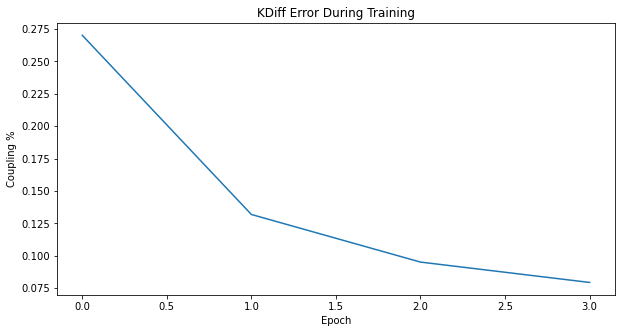

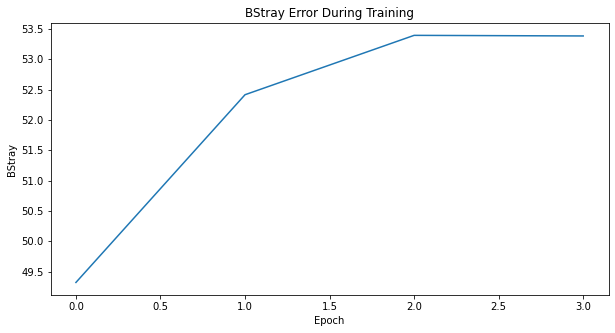

In [35]:
plt.figure(figsize=(10, 5))
plt.title(f"KDiff Error During Training")
plt.xlabel("Epoch")
plt.ylabel("Coupling %")

plt.plot(numpy.arange(len(kdiffs)), kdiffs)
plt.show()


plt.figure(figsize=(10, 5))
plt.title(f"BStray Error During Training")
plt.xlabel("Epoch")
plt.ylabel("BStray")

plt.plot(numpy.arange(len(bstrays)), bstrays)
plt.show()